In [1]:
import numpy as np
import pylab as plt
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline
import matplotlib.pylab as plt
import control as ctrl

In [17]:
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

## CT-LQR infinite horizon

In [85]:
T = 10 #total time (s)
dt = 1e-2
I = 6 #kg, inertia
D = -0.2 #N/m damping
G = np.array([[10,0],[0,1]]) #Gamma, observer gain
a = 10^4 #learning rate
Q = Qh = np.array([[100,0],[0,0]])
R = np.array([[1]])

A = np.array([[0,1],[0,-(1/I)*D]])
B = np.array([[0],[1/I]])

#initial state (x-xd)
s0 = np.array([-0.1,0]) # start with position 0, i.e. s = x-xd = 0-0.1

#10 reach back and forward (-10 ~ +10 cm), step "ref"
# ref = np.array([0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1])
# xd = np.repeat(ref, int(T/10/dt)/2)

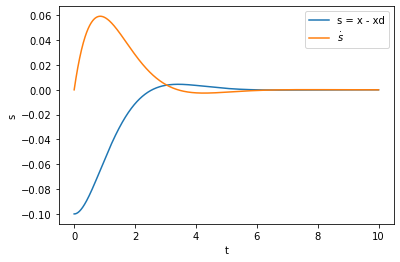

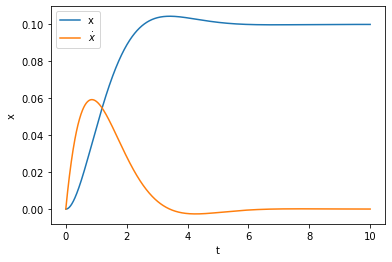

In [86]:
# (1) CT-LQR
K,_,_ = ctrl.lqr(A,B,Q,R)

def f(t,s,u):
    return np.dot(A,s) + np.dot(B,u)
us = lambda x: -np.dot(K,x)

t_,s_ = numerical_simulation(f,T,s0,t0=0.,dt=dt,ux=us)

plt.plot(t_,s_[:,0], label= 's = x - xd')
plt.plot(t_,s_[:,1], label= r'$\dot s$')
plt.ylabel('s')
plt.xlabel('t')
plt.legend()
plt.show()

xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
plt.plot(t_,s_[:,0]+ xd, label= 'x')
plt.plot(t_,s_[:,1], label= r'$\dot x$')
plt.ylabel('x')
plt.xlabel('t')
plt.legend()
plt.show()

## DT-LQR infinite horizon

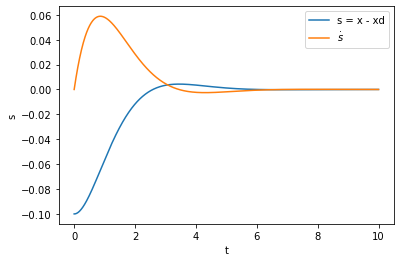

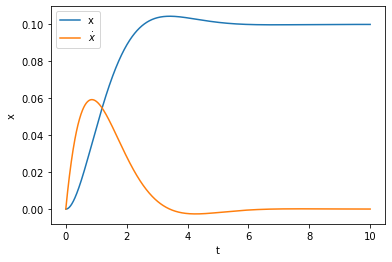

In [109]:
# (1) DT-LQR
A = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]])
B = dt * np.array([[0],[1/I]])
Q = dt * np.array([[100,0],[0,0]]) # running state cost
R = dt * np.array([[1]]) # running control cost
P = la.solve_discrete_are(A,B,Q,R)
K,_,_ = ctrl.dlqr(A,B,Q,R) #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))

#initial state (x-xd)
ds0 = np.array([-0.1,0]) # start with position 0, i.e. s = x-xd = 0-0.1
ds = np.zeros((int(T/dt)+1,2))
ds[0] = ds0
du = np.zeros((int(T/dt),1)) #np.zeros((int(T/dt),1,1))

for t in range(int(T/dt)):
  du[t] = np.dot(-K,ds[t])                        # calculate optimal input
  # ct[t] = 0.5 * np.dot(ds[t].T, np.dot(Q, ds[t])) + \
  #       np.dot(du[t].T, np.dot(R, du[t]))  # calculate cost        
  ds[t+1] = np.dot(A,ds[t]) + np.dot(B, du[t])        # calculate next state

plt.plot(t_,ds[:,0], label= 's = x - xd')
plt.plot(t_,ds[:,1], label= r'$\dot s$')
plt.ylabel('s')
plt.xlabel('t')
plt.legend()
plt.show()

xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
plt.plot(t_,s_[:,0]+ xd, label= 'x')
plt.plot(t_,s_[:,1], label= r'$\dot x$')
plt.ylabel('x')
plt.xlabel('t')
plt.legend()
plt.show()

In [ ]:
# (2) collabration, robot: Q, human: Qh

#initialize Q, Qh, u, uh, sh, Ph



for t in range(int(T/dt)):
    #calculate the estimation error se and estimated state sh
    se = sh - s
    sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t] + uh[t]) 


